# **Rodrigo_Mesquita_PB_TP2**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]** 

## 1.Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar a importância das palavras em um conjunto de documentos.


In [2]:
!pip install gdown

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gdown

In [4]:
url = 'https://drive.google.com/file/d/1pvjGFAWwZ42cPmFVNf0tOGSPpL0YEOif/view?usp=drive_link'
output = '/workspaces/Faculdade/Datasets/emotions.csv'
gdown.download(url=url, output=output, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1pvjGFAWwZ42cPmFVNf0tOGSPpL0YEOif
To: /workspaces/Faculdade/Datasets/emotions.csv
100%|██████████| 44.9M/44.9M [00:00<00:00, 84.5MB/s]


'/workspaces/Faculdade/Datasets/emotions.csv'

In [5]:
df = pd.read_csv('/workspaces/Faculdade/Datasets/emotions.csv')

In [6]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [7]:
df = df.drop('Unnamed: 0', axis=1)

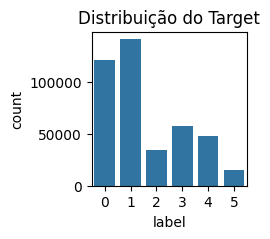

In [8]:
plt.figure(figsize=(2,2))
plt.title('Distribuição do Target')
sns.countplot(df, x='label')
plt.show()

In [9]:
#Tive de reduzir o tamanho do Dataset pois o Kernel estava sendo encerrado
df_slice = df.iloc[0:15000].copy()

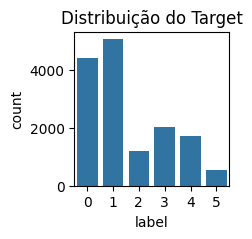

In [10]:
plt.figure(figsize=(2,2))
plt.title('Distribuição do Target')
sns.countplot(df_slice, x='label')
plt.show()

In [11]:
x = df_slice.drop(['label'], axis=1)
y = df_slice['label']

In [12]:
# Calculando o TF-IDF
tfidf_vectorizer = TfidfVectorizer(lowercase=True, min_df=5)
tfidf_matrix = tfidf_vectorizer.fit_transform(x['text'])

# Convertendo a matriz TF-IDF para um DataFrame
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns= tfidf_vectorizer.get_feature_names_out())

# Exibindo as palavras com maior pontuação:
print(df_tfidf.loc[0].sort_values(ascending=False).head(10))

heavy        0.684941
helpless     0.535081
really       0.333609
just         0.304617
and          0.158370
feel         0.124001
presents     0.000000
press        0.000000
pressure     0.000000
pressured    0.000000
Name: 0, dtype: float64


## 2.Modelagem de K-Nearest Neighbors (KNN): Criar modelos simples de classificação utilizando a base de dados codificada por TF-IDF.


In [13]:
x_train,x_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.3, random_state=20)

In [14]:
valor_k = list(range(3,40,2))

model = KNeighborsClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Acuracia:', accuracy_score(y_test.values.ravel(),y_pred))

Acuracia: 0.7046666666666667


## 2.a. Explore diferentes valores para o parâmetro K do KNN e analise seu impacto nos resultados obtidos (através da acurácia do modelo para os dados de validação).


### O melhor valor para o parâmetro foi K=21

In [15]:
valor_k = list(range(3,40,2))
score, acc_train, acc_test = [],[],[]

for k in valor_k:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)    
    y_test_pred = model.predict(x_test)
    acc_train.append(accuracy_score(y_train.values.ravel(),y_train_pred))
    acc_test.append(accuracy_score(y_test.values.ravel(),y_test_pred))

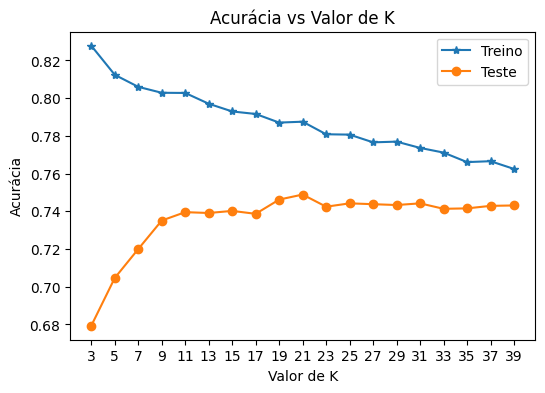

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(valor_k, acc_train, marker='*')
plt.plot(valor_k, acc_test, marker='o')
plt.title('Acurácia vs Valor de K')
plt.ylabel('Acurácia')
plt.xlabel('Valor de K')
plt.legend(['Treino','Teste'])
plt.xticks(valor_k)
plt.show()

## 3.Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [18]:
#Treinando o modelo com CrossValidation

model = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(3,40,2))}

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39]})

In [19]:
best_estimator = grid.best_estimator_
scores = cross_val_score(best_estimator, x_train, y_train, cv=5)

# Imprimindo os resultados
print("Melhor valor de K:", grid.best_params_['n_neighbors'])
print("Maior score da validação cruzada:", max(scores))
print("Média dos scores de validação cruzada:", np.mean(scores))

Melhor valor de K: 23
Maior score da validação cruzada: 0.7333333333333333
Média dos scores de validação cruzada: 0.7300952380952381



## 4.Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade para avaliar os modelos.

In [20]:
#Transformando meu label em binário (Juntei as classes de emoções positivas para deixar menos desbalanceado)
df_slice['target'] = df_slice['label'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
y = df_slice['target']

#Separando de novo em treino e teste.
x_train,x_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.3, random_state=20)

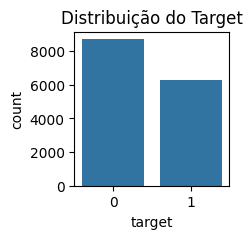

In [21]:
#Checando a distribuição
plt.figure(figsize=(2,2))
plt.title('Distribuição do Target')
sns.countplot(df_slice, x='target')
plt.show()

In [25]:
#Treinando de novo, utilizando o melhor K encontrado anteriormente, e usando a coluna binária no Y
model = KNeighborsClassifier(n_neighbors = 23)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
print(accuracy_score(y_test.values.ravel(),y_test_pred))

0.8646666666666667


In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [28]:
results = {
    'accuracy_train': accuracy_score(y_pred = y_train_pred, y_true= y_train), 
    'accuracy_test': accuracy_score(y_pred = y_test_pred, y_true=y_test),
    'recall_train': recall_score(y_pred = y_train_pred, y_true=y_train),
    'recall_test': recall_score(y_pred = y_test_pred, y_true=y_test),
    'precision_train': precision_score(y_pred = y_train_pred, y_true=y_train),
    'precision_test':precision_score(y_pred = y_test_pred, y_true=y_test),
    'f1_train': f1_score(y_pred = y_train_pred, y_true=y_train),
    'f1_test': f1_score(y_pred = y_test_pred, y_true=y_test),
    'cm_train': confusion_matrix(y_pred = y_train_pred, y_true=y_train),
    'cm_test': confusion_matrix(y_pred = y_test_pred, y_true=y_test)
}

In [29]:
results

{'accuracy_train': 0.8883809523809524,
 'accuracy_test': 0.8646666666666667,
 'recall_train': 0.7935779816513762,
 'recall_test': 0.7571801566579635,
 'precision_train': 0.9271168274383709,
 'precision_test': 0.9096612296110415,
 'f1_train': 0.8551655956500247,
 'f1_test': 0.8264462809917356,
 'cm_train': array([[5868,  272],
        [ 900, 3460]]),
 'cm_test': array([[2441,  144],
        [ 465, 1450]])}

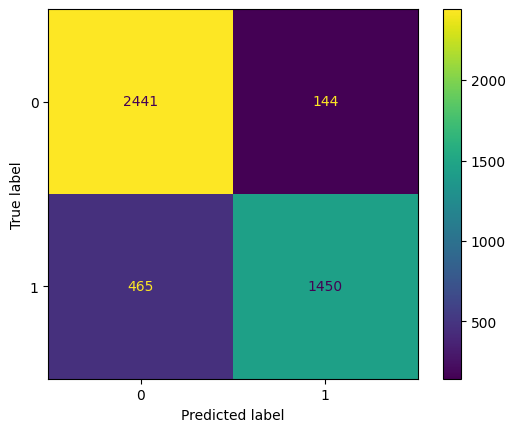

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix=results['cm_test'], display_labels=model.classes_)
disp.plot()

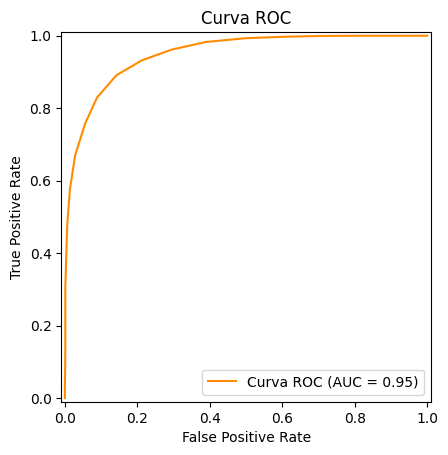

In [31]:
from sklearn.metrics import RocCurveDisplay;

display = RocCurveDisplay.from_estimator(
        model,
        x_test,
        y_test,
        name="Curva ROC",
        color="darkorange",
    )
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Curva ROC",
)

plt.show()

## 5.Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência do classificador criado.

O modelo ficou com acurácia elevada e boa precisão (90%), ou seja a maior parte do que está sendo previsto como Positivo, realmente é. No entanto, o recall de 75% indica que há Positivos sendo classificados indevidamente como Negativos, então há espaço para melhorar o modelo.